# Time-Decaying Gaussian Process UCB Algorithms
## Minimal Verifying Problem

See ideas at https://www.dropbox.com/s/krqreih872ionmo/%5BIdea%5D%20GP-t%20Algorithm.pdf?dl=0

In [26]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import sys
sys.path.append('../')
import scriptinit
import numpy as np
import numpy.random as npr
import numpy.linalg as npla
from matplotlib.pyplot import *
from pyrl.algorithms.uvfa import *
from pyrl.algorithms.valueiter import *
from pyrl.tasks.gridworld import *
from pyrl.algorithms.nn import *
from pyrl.agents.agent import *
from pyrl.agents.multitask import *
from pyrl.algorithms.multitask import *
import pyrl.agents.arch as arch
from pyrl.prob import *
from pyrl.utils import *

In [2]:
def showV(v):
    imshow(v.reshape(H, W), interpolation='none')
    print v

# World

[[ 0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.]
 [ 0.  0.  1.  1.  0.  0.]
 [ 0.  0.  1.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.]]


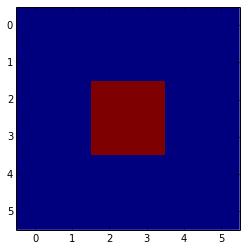

In [5]:
# world 2
H = W = 6
grid = np.zeros((H, W))
grid[2:4, 2:4] = 1.
showV(grid)

In [10]:
all_tasks = generate_gridworlds(grid)
random.shuffle(all_tasks)
tasks = all_tasks[:4]

# Network Architecture

In [218]:
# neural network architecture.
# shared weights between state and goal due to symmetry.
def two_stream_arch(states, input_dim=H * W, output_dim=4):
    params = []
    ## agent.
    H_AGENT_DIM1 = 8
    fc_agent1 = layers.FullyConnected(input_dim, H_AGENT_DIM1, activation='relu')
    h_agent1 = fc_agent1(states[:, :input_dim])
    h_goal1 = fc_agent1(states[:, input_dim:2*input_dim]) # shared weights.
    ## combine them all!
    v_joint = T.concatenate([h_agent1, h_goal1], axis=1)
    H_JOINT_DIM = 32
    fc_joint = layers.FullyConnected(2 * H_AGENT_DIM1, H_JOINT_DIM, activation='relu')
    linear_layer = layers.FullyConnected(H_JOINT_DIM, output_dim, activation=None)
    
    output = linear_layer(fc_joint(v_joint))
    
    model = {
        'fc_agent1': fc_agent1,
        'fc_joint': fc_joint,
        'linear_layer': linear_layer
    }
    return (output, model)



### distance metric.

In [219]:
def dist(task1, task2):
    pos1 = task1.goal.keys()[0]
    pos2 = task2.goal.keys()[0]
    return np.abs(pos1[0] - pos2[0])+ np.abs(pos1[1] - pos2[1])

In [227]:
#dqn = DQN(tasks[0], lambda states: arch.two_layer(states, H * W * 2, 32, 4))
dqn = DQN(tasks[0], two_stream_arch)
learner = SingleLearnerGPt(dqn, tasks, dist=dist, 
                           gpt_eta=1e-2, gpt_r=1. / (H + W), gpt_v=1e-2, gpt_sigma=1e-1, gpt_kappa=1e-2,
                           lr=1e-4, memory_size=250)


[chosen task]  1
mu None
sigma None
ucb None
performance 0.0938175353254 progress 0.0270039060612
task rewards [ 0.08492933  0.13607545  0.09866171  0.05560365]
[chosen task]  1
mu [ 0.00166446  0.01336761  0.01229879  0.00166446]
sigma [ 0.01992402  0.01509901  0.0158514   0.01992402]
ucb [ 0.0018637   0.0135186   0.01245731  0.0018637 ]
performance 0.103514835314 progress 0.00969729998901
task rewards [ 0.08667918  0.16978796  0.10752151  0.05007069]
[chosen task]  1
mu [ 0.00145956  0.01172203  0.01078479  0.00145956]
sigma [ 0.01990127  0.0136317   0.01460935  0.01990127]
ucb [ 0.00165858  0.01185835  0.01093088  0.00165858]
performance 0.0880043893665 progress -0.0155104459479
task rewards [ 0.08342787  0.1300665   0.100106    0.03841719]
[chosen task]  1
mu [ 0.00044287  0.00355674  0.00327236  0.00044287]
sigma [ 0.01989248  0.01306496  0.01412962  0.01989248]
ucb [ 0.00064179  0.00368739  0.00341365  0.00064179]
performance 0.109449672917 progress 0.0214452835503
task rewards [

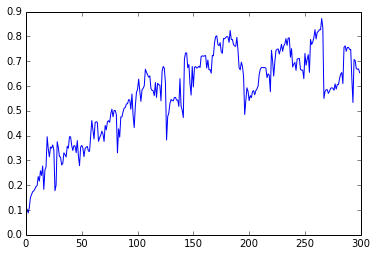

In [228]:
performances = []
for it in range(300):
    learner.run(num_epochs=1, num_episodes=10)
    print '[chosen task] ', learner.last_task_ti
    print 'mu', learner.mu
    print 'sigma', learner.sigma
    print 'ucb', learner.ucb
    print 'performance', learner.last_performance, 'progress', learner.last_progress
    print 'task rewards', learner.last_task_performance
    performances.append(learner.last_performance)
plot(performances)

it 0 train_performances 0.0920402622854
it 1 train_performances 0.118992880796
it 2 train_performances 0.111199549655
it 3 train_performances 0.158559723869
it 4 train_performances 0.143333253018
it 5 train_performances 0.175929883115
it 6 train_performances 0.212811111651
it 7 train_performances 0.203952869289
it 8 train_performances 0.203841818267
it 9 train_performances 0.168441968753
it 10 train_performances 0.205722833504
it 11 train_performances 0.213745465055
it 12 train_performances 0.209761377041
it 13 train_performances 0.198638274656
it 14 train_performances 0.190825329038
it 15 train_performances 0.225280792989
it 16 train_performances 0.226469680511
it 17 train_performances 0.241584462069
it 18 train_performances 0.23093182572
it 19 train_performances 0.247481650669
it 20 train_performances 0.257738181684
it 21 train_performances 0.26055848244
it 22 train_performances 0.273504328721
it 23 train_performances 0.260772491393
it 24 train_performances 0.259608361495
it 25 train

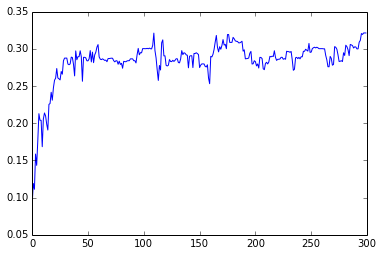

In [226]:
#dqn = DQN(tasks[0], lambda states: arch.two_layer(states, H * W * 2, 32, 4))
dqn = DQN(tasks[0], two_stream_arch)
learner = SingleLearnerSequential(dqn, tasks, 
                           lr=1e-4, memory_size=250)
train_performances = []
for it in range(300):
    learner.run(num_epochs = 1, num_episodes = 10)
    train_performances.append(eval_dataset(dqn, tasks))
    print 'it', it, 'train_performances', train_performances[-1]
plot(train_performances)


In [172]:
np.diag(learner.sigma)

array([[ 1.19458254,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  1.14922715,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  1.26598974,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  1.12498521]])

In [121]:
train_errors = []
for it in range(300):
    learner.run(num_epochs = 1, num_episodes = 10)
    train_errors.append(eval_dataset(dqn, tasks2))
    print 'it', it, 'train_err', train_errors[-1]
figure(1)
plot(train_errors)

NameError: name 'tasks2' is not defined